In [1]:
#from __future__ import division, print_function
import numpy as np
import matplotlib.pyplot as plt
import skfuzzy as fuzz
from skfuzzy import control as ctrl
from scipy import ndimage
from scipy import interpolate
import numpy.matlib
import warnings
warnings.filterwarnings('ignore')
np.set_printoptions(threshold='nan')
from matplotlib.colors import from_levels_and_colors
import matplotlib.colors as mcolors
import glob
import os
from numpy.lib.stride_tricks import as_strided as strided
import matplotlib
import pandas as pd
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1 import AxesGrid
import matplotlib.colors as colors



In [2]:
def beam_height_n(r, theta, re=6374000., ke=4./3.):
    return np.sqrt( r**2 + (ke*re)**2 + 2*r*ke*re*np.sin(np.radians(theta)) ) - ke*re
def cmap_discretize(cmap, N):
    """Return a discrete colormap from the continuous colormap cmap.

        cmap: colormap instance, eg. cm.jet. 
        N: number of colors.

    Example
        x = resize(arange(100), (5,100))
        djet = cmap_discretize(cm.jet, 5)
        imshow(x, cmap=djet)
    """

    if type(cmap) == str:
        cmap = plt.get_cmap(cmap)
    colors_i = np.concatenate((np.linspace(0, 1., N), (0.,0.,0.,0.)))
    colors_rgba = cmap(colors_i)
    indices = np.linspace(0, 1., N+1)
    cdict = {}
    for ki,key in enumerate(('red','green','blue')):
        cdict[key] = [ (indices[i], colors_rgba[i-1,ki], colors_rgba[i,ki])
                       for i in xrange(N+1) ]
    # Return colormap object.
    return mcolors.LinearSegmentedColormap(cmap.name + "_%d"%N, cdict, 1024)
def nan_helper(y):
    """Helper to handle indices and logical indices of NaNs.

    Input:
        - y, 1d numpy array with possible NaNs
    Output:
        - nans, logical indices of NaNs
        - index, a function, with signature indices= index(logical_indices),
          to convert logical indices of NaNs to 'equivalent' indices
    Example:
        >>> # linear interpolation of NaNs
        >>> nans, x= nan_helper(y)f
        >>> y[nans]= np.interp(x(nans), x(~nans), y[~nans])
    """

    return np.isnan(y), lambda z: z.nonzero()[0]
class FixPointNormalize(matplotlib.colors.Normalize):
    """ 
    Inspired by https://stackoverflow.com/questions/20144529/shifted-colorbar-matplotlib
    Subclassing Normalize to obtain a colormap with a fixpoint 
    somewhere in the middle of the colormap.

    This may be useful for a `terrain` map, to set the "sea level" 
    to a color in the blue/turquise range. 
    """
    def __init__(self, vmin=None, vmax=None, sealevel=0, col_val = 0.21875, clip=False):
        # sealevel is the fix point of the colormap (in data units)
        self.sealevel = sealevel
        # col_val is the color value in the range [0,1] that should represent the sealevel.
        self.col_val = col_val
        matplotlib.colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.sealevel, self.vmax], [0, self.col_val, 1]
        return np.ma.masked_array(np.interp(value, x, y))
def mask_knans(a, x):
    #Interpolates, then masks interpolated values if over a certain threshold.
    a = np.asarray(a)
    k = a.size
    n = np.append(np.isnan(a), [False] * (x - 1))
    m = np.empty(k, np.bool8)
    m.fill(True)

    s = n.strides[0]
    i = np.where(strided(n, (k + 1 - x, x), (s, s)).all(1))[0][:, None]
    i = i + np.arange(x)
    i = pd.unique(i[i < k])

    m[i] = False

    return m


# set the colormap and centre the colorbar
class MidpointNormalize(colors.Normalize):
	"""
	Normalise the colorbar so that diverging bars work there way either side from a prescribed midpoint value)

	e.g. im=ax1.imshow(array, norm=MidpointNormalize(midpoint=0.,vmin=-100, vmax=100))
	"""
	def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
		self.midpoint = midpoint
		colors.Normalize.__init__(self, vmin, vmax, clip)

	def __call__(self, value, clip=None):
		# I'm ignoring masked values and all kinds of edge cases to make a
		# simple example...
		x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
		return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))



In [3]:
#Reading in the S band QVP data
dir_name='/Users/brandonh/Documents/Data/Refreezing cases/'
with open('/Users/brandonh/Documents/Data/Refreezing cases/FdpPrfl_KTLX06_40.dat','r') as f:
    df = pd.DataFrame(l.rstrip().split() for l in f)



#The data format is format='(7F12.4,I5)', $ dist(i),height,Z(i),Zdr(i),Rhv(i),Fdp(i),Kdp(i),NumOfScan
#For KTLX (20140302) case, elevation angle is 6.4 deg. There are 680 heights for each scan and total scan number is 79.
#For KOHX (20140301) case, elevation angle is 6.0 deg. There are 724 heights for each scan and total scan number is 69.

height=np.asarray(df[[1]])
ref=np.asarray(df[[2]])
dref=np.asarray(df[[3]])
rhv=np.asarray(df[[4]])
ff=np.asarray(df[[5]])
kk=np.asarray(df[[6]])
scan=np.asarray(df[[7]])

h=np.zeros(len(height))
zh=np.zeros(len(height))
zdr=np.zeros(len(height))
rho=np.zeros(len(height))
fdp=np.zeros(len(height))
kdp=np.zeros(len(height))
num_scans=np.zeros(len(height))


for ii in range(len(height)):
    h[ii]=float(height[ii][0])
    zh[ii]=float(ref[ii][0])
    zdr[ii]=float(dref[ii][0])
    rho[ii]=float(rhv[ii][0])
    fdp[ii]=float(ff[ii][0])
    kdp[ii]=float(kk[ii][0])
    num_scans[ii]=float(scan[ii][0])

    
h=h.reshape(79,680)
zh=zh.reshape(79,680).transpose()
zdr=zdr.reshape(79,680).transpose()
rhohv=rho.reshape(79,680).transpose()
fdp=fdp.reshape(79,680).transpose()
kdp=kdp.reshape(79,680).transpose()
num_scans=num_scans.reshape(79,680)

beam_height=h[0,:]
tradar=np.linspace(18.45,24,79)

zht=np.copy(zh)
rhoct=np.copy(rhohv)
zdrt=np.copy(zdr)

kdp[(zht<-10)|(rhoct>1)|(rhoct<.8)|(zdrt<-1)]=np.nan
zdr[(zht<-10)|(rhoct>1)|(rhoct<.8)|(zdrt<-1)]=np.nan
rhohv[(zht<-10)|(rhoct>1)|(rhoct<.8)|(zdrt<-1)]=0
zh[(zht<-10)|(rhoct>1)|(rhoct<.8)|(zdrt<-1)]=np.nan


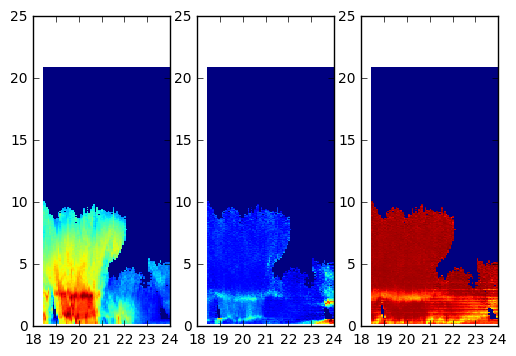

In [35]:
#fig,ax=plt.subplot(nrows=1,ncols=3)
plt.subplot(1,3,1)
plt.pcolormesh(tradar,beam_height,zh,vmin=-10,vmax=30)
plt.subplot(1,3,2)
plt.pcolormesh(tradar,beam_height,zdr,vmin=-1,vmax=3)
plt.subplot(1,3,3)
plt.pcolormesh(tradar,beam_height,rhohv,vmin=.7,vmax=1)
plt.show()


In [17]:
#RUC temp data

file_path='/Users/brandonh/Documents/Data/RUC_data/KTLX/'
file_names = sorted(glob.glob( os.path.join(file_path, '*.txt')))
ruc_h=[]
twetbulb=[]

for ii in range(len(file_names)) : 
    fname=file_names[ii]
    with open(fname,'r') as f:
        #next(f) # skip first row
        df = pd.DataFrame(l.rstrip().split() for l in f)
    twb=np.asarray(df[[5]])
    twetbulb.append(twb[6:,0].astype(np.float))
    ruc_height=np.asarray(df[[1]])
    ruc_h.append(ruc_height[6:,0].astype(np.float))
ruc_h=np.asarray(ruc_h)
twetbulb=np.asarray(twetbulb)
tt=np.arange(18,24)

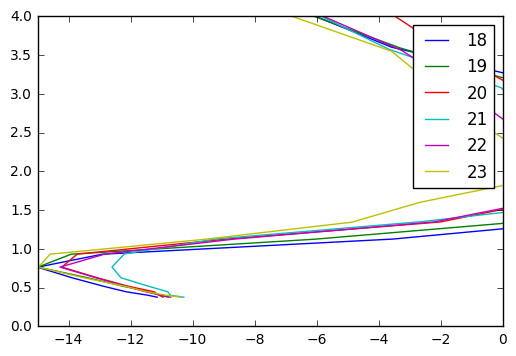

In [19]:
for n in range(ruc_h.shape[0]):
    labels=file_names[n]
    labels=labels[-6:-4]
    plt.plot(twetbulb[n,:],ruc_h[n,:]/1000,label=labels)
    plt.legend()
    plt.ylim(0,4)
    plt.xlim(-15,0)
plt.show()




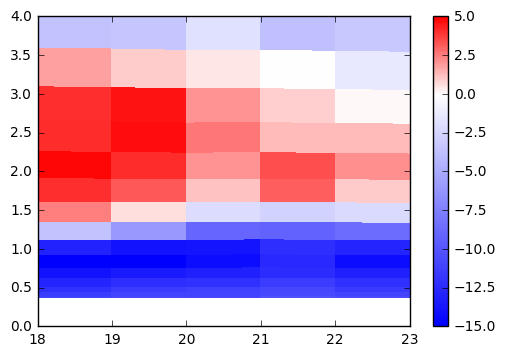

In [23]:
a = np.array([0, 1, 2])
aa=np.array([tt,]*48).transpose()

elev_min=-15
elev_max=5
mid_val=0
cmap='bwr'

plt.pcolormesh(aa,ruc_h/1000,twetbulb, cmap=cmap, clim=(elev_min, elev_max), norm=MidpointNormalize(midpoint=mid_val,vmin=elev_min, vmax=elev_max))
plt.colorbar()
plt.ylim(0,4)
plt.show()

'''plt.pcolormesh(aa,ruc_h/1000,twetbulb,vmin=-12,vmax=0,cmap='coolwarm')
plt.ylim(0,3)
plt.colorbar()'''
plt.show()


In [24]:
######## MELTING LAYER DETECTION ########

#qvp_zh=qvp_data[:,:,0]#+zh_offset
qvp_zh=np.copy(zh)
z0=np.zeros((qvp_zh.shape[0],qvp_zh.shape[1])) 
rho0=np.zeros((qvp_zh.shape[0],qvp_zh.shape[1]))
zdr0=np.zeros((qvp_zh.shape[0],qvp_zh.shape[1]))
kdp0=np.zeros((qvp_zh.shape[0],qvp_zh.shape[1]))
hmask=np.where((beam_height>3)|(beam_height<1.5))#|(beam_height<1.5))#|(beam_height<1))
##################
for ii in range(z0.shape[1]):
    #normalize Z
    z=np.copy(zh[:,ii])
    zmask= np.where((z < 0) | (z>60))
    z[zmask]=np.nan
    z[hmask]=np.nan
    z0[:,ii]=(z-np.nanmin(z))/(np.nanmax(z)-np.nanmin(z))

    #normalize rho
    rho=np.copy(rhohv[:,ii])
    rhomask= np.where((rho <0.8) | (rho>.97)) 
    rho[rhomask]=np.nan
    rho[hmask]=np.nan
    rho0[:,ii]=(rho-np.nanmin(rho))/(np.nanmax(rho)-np.nanmin(rho))

    #normalize ZDR
    zd=np.copy(zdr[:,ii])
    zdmask= np.where((zd < 0)|(zd > 4))
    zd[zdmask]=np.nan
    zd[hmask]=np.nan
    zdr0[:,ii]=(zd-np.nanmin(zd))/(np.nanmax(zd)-np.nanmin(zd))

    #normalize kdp
    kd=np.copy(kdp[:,ii])
    kdpmask= np.where((kd <0) | (kd>.5)) 
    #rho[rhomask]=np.nan
    kd[hmask]=np.nan
    kdp0=(kd-np.nanmin(kd))/(np.nanmax(kd)-np.nanmin(kd))


    
#################
i=zdr0*(1-rho0)
i[np.isnan(i)]=0
dz=ndimage.sobel(i,0)
#dz[abs(dz)<.02]=np.nan
#################
top=np.zeros(dz.shape[1])
bot=np.zeros(dz.shape[1])
for ii in range(dz.shape[1]):
    d=pd.rolling_median(dz[:,ii],4,min_periods=1)
    if np.nansum(np.abs(d))>0:
        t=np.nanargmin(d,0)
        b=np.nanargmax(d,0)
        top[ii]=beam_height[t]
        bot[ii]=beam_height[b]
    else:
        top[ii]=np.nan
        bot[ii]=np.nan
    if bot[ii]>top[ii]:
        bot[ii]=np.nan
        
tt=np.copy(top)
bt=np.copy(bot)
##################
r=3
a=top
x=[]
m=np.zeros(len(a))
above=np.empty(len(a))
tout=np.empty(len(a))
for ii in range(len(a)):
    if ~np.isnan(a[ii]):
        x.append(a[ii])
        x2=np.asarray(x)
        if ii<=1:
            m[ii]=np.asarray(a[ii])
            #m[ii]=x2[ii]
            #print ii, m[ii]
        elif (ii>1)&(ii<r):
            m[ii]=np.nanmedian(x2[len(x2)-len(x2):len(x2)-1])
        else:
            m[ii]=np.nanmedian(x2[len(x2)-r:len(x2)-1])
            
    elif np.isnan(a[ii]):
        m[ii]=np.nan
    
    above[ii]=np.abs(a[ii]-m[ii])
    if above[ii]>1:
        x=x[:-1]
        #x[len(x2)-1]=np.nan
        #print len(x2),x[:len(x2)]
        tout[ii]=np.nan
    else:
        tout[ii]=m[ii]    
  

b=bot
x=[]
m=np.zeros(len(a))
below=np.empty(len(a))
bout=np.empty(len(a))
for ii in range(len(a)):
    if ~np.isnan(b[ii]):
        x.append(b[ii])
        x2=np.asarray(x)
        if ii<=1:
            m[ii]=np.asarray(a[ii])
            #print ii, m[ii]
        elif (ii>1)&(ii<r):
            m[ii]=np.nanmedian(x2[len(x2)-len(x2):len(x2)-1])
        else:
            m[ii]=np.nanmedian(x2[len(x2)-r:len(x2)-1])
            
    elif np.isnan(b[ii]):
        m[ii]=np.nan
    
    below[ii]=np.abs(b[ii]-m[ii])
    if below[ii]>1:
        x=x[:-1]
        #x[len(x2)-1]=np.nan
        #print len(x2),x[:len(x2)]
        bout[ii]=np.nan
    else:
        bout[ii]=m[ii] 

        
top[(np.isnan(tout))|(np.isnan(bout))]=np.nan
bot[(np.isnan(bout))|(np.isnan(tout))]=np.nan


##################   
#qvp_data=np.load(file_name)
#rho=qvp_data[:,:,2]
rho=np.copy(rhohv)
#hmask=np.where(beam_height>2)
topnew=np.empty(len(top))
botnew=np.empty(len(top))
for ii in range(rho.shape[1]):
    #print ii
    r=np.copy(rho[:,ii])
    r[hmask]=np.nan

    tm=np.where(beam_height<top[ii])
    bm=np.where(beam_height>bot[ii])
    r2=np.copy(r)
    r3=np.copy(r)
    r2[tm]=np.nan
    r3[bm]=np.nan
    if np.nansum(np.abs(r2))>0:
        if ~np.isnan(top[ii]):
            if np.nanmax(r2)>=.97:
                t97=np.where(r2>=.97)
                indtop=t97[0]
                topnew[ii]=beam_height[indtop[0]]
            else:
                t97=np.nanargmax(r2)
                topnew[ii]=beam_height[t97]
        else:
            topnew[ii]=np.nan
    if ~np.isnan(bot[ii]):   
        if np.nanmax(r3)>=.97:
            b97=np.where(r3>=.97)    
            indbot=b97[0]
            botnew[ii]=beam_height[indbot[-1]]
        else:
            b97=np.nanargmax(r3)
            botnew[ii]=beam_height[b97]
    else:
        botnew[ii]=np.nan
#indtop=t97[0]
    #indbot=b97[0]
    #topnew[ii]=beam_height[indtop[0]]
    #botnew[ii]=beam_height[indbot[-1]]
mlt=np.copy(topnew)
mlb=np.copy(botnew)


####INTERPOLATION####
##TOP
y= np.copy(mlt)
nans, x= nan_helper(y)
y[nans]= np.interp(x(nans), x(~nans), y[~nans])
x2=np.arange(zh.shape[1])
ynan=np.where(~np.isnan(mlt))
y[0:ynan[0][0]]=np.nan
y[ynan[0][-1]+1:]=np.nan
mltnew=np.copy(y)

##BOT
y= np.copy(mlb)
nans, x= nan_helper(y)
y[nans]= np.interp(x(nans), x(~nans), y[~nans])
x2=np.arange(zh.shape[1])
ynan=np.where(~np.isnan(mlb))
y[0:ynan[0][0]]=np.nan
y[ynan[0][-1]+1:]=np.nan
mlbnew=np.copy(y)

#a = np.array([1, np.nan, np.nan, np.nan, 3, np.nan, 4, 5, np.nan, np.nan, 6, 7])
am=mask_knans(mlt, 8)
mltnew[am==False]=np.nan
am=mask_knans(mlb, 8)
mlbnew[am==False]=np.nan


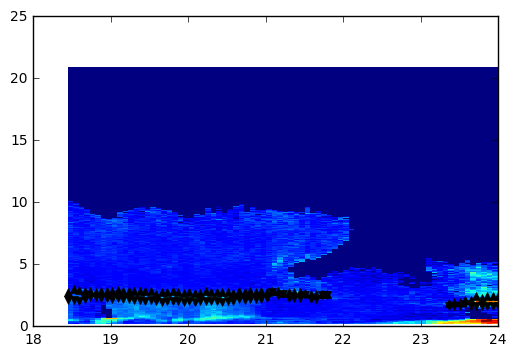

In [25]:
plt.pcolormesh(tradar,beam_height,zdr,vmin=-1,vmax=3)
plt.plot(tradar,mlt,'k^')
plt.plot(tradar,mlb,'kv')

plt.show()

In [62]:
# New Antecedent/Consequent objects hold universe variables and membership
# functions
mz=np.arange(-20, 70, .5)
mzh = ctrl.Antecedent(mz, 'refl.')
mzh_OT = fuzz.trapmf(mzh.universe, [-10, 3, 28,43])
mzh_WS = fuzz.trapmf(mzh.universe, [-0.2, 7.7,42.3,50.1])
mzh_FZ = fuzz.trapmf(mzh.universe, [-20.1,-14.4, 36.4, 43.6])
mzh_RN = fuzz.trapmf(mzh.universe, [-16.,-11, 49, 54.])
mzh_PL = fuzz.trapmf(mzh.universe, [-4.4, 0.8, 23.2, 28.4])
mzh_DN = fuzz.trapmf(mzh.universe, [-5.2, 6.6, 27.4, 39.2])
mzh_IC = fuzz.trapmf(mzh.universe, [-11.4,-2.2, 14.2, 23.4])
mzh_AG = fuzz.trapmf(mzh.universe, [ 12.9, 17.6, 38.4, 43.1])
mzh_GR = fuzz.trapmf(mzh.universe, [ 25, 35, 50, 55])
mzh_RM = fuzz.trapmf(mzh.universe, [ 25, 35, 50, 55])

md=np.arange(-4, 12, .1)
mzdr = ctrl.Antecedent(md, 'diff refl')
mzdr_OT = fuzz.trapmf(mzdr.universe, [-1.2,-0.9, 1.9, 2.2])
mzdr_WS = fuzz.trapmf(mzdr.universe, [-3.8,-1.8, 6.8, 8.8])
mzdr_PL = fuzz.trapmf(mzdr.universe, [ 0.8, 2.3, 8.7, 10.2])
mzdr_DN = fuzz.trapmf(mzdr.universe, [ 1., 1.5, 3.7, 4.2])
mzdr_IC = fuzz.trapmf(mzdr.universe, [-0.9,-0.4, 0.4, 0.9])
mzdr_AG = fuzz.trapmf(mzdr.universe, [-1.1,-0.9, 0.9, 1.1])
mzdr_GR = fuzz.trapmf(mzdr.universe, [-0.3,0, 1, 1.3])

mk=np.arange(-1, 4, .1)
mkdp = ctrl.Antecedent(mk, 'spec phase shift')
mkdp_PL = fuzz.trapmf(mkdp.universe, [-0.3, 0.1, 0.8, 1.2])
mkdp_DN = fuzz.trapmf(mkdp.universe, [-0.7, 0.4, 2.3, 3.3])
mkdp_IC = fuzz.trapmf(mkdp.universe, [-0.9,-0.4, 0.4, 0.9])
mkdp_AG = fuzz.trapmf(mkdp.universe, [-0.9,-0.4, 0.4, 0.9])

mr=np.arange(0, 1.3, .01)
mrho = ctrl.Antecedent(mr, 'corr coef')
mrho_OT = fuzz.trapmf(mrho.universe, [.88,.91,1,1.01])
mrho_WS = fuzz.trapmf(mrho.universe, [.55,.6,.94,.97])
mrho_FZ = fuzz.trapmf(mrho.universe, [.95,.97,1,1.01])
mrho_RN = fuzz.trapmf(mrho.universe, [.92,.95,1,1.01])
mrho_GR = fuzz.trapmf(mrho.universe, [.90,.97,1,1.01])


# Auto-membership function population is possible with automf(3, 5, or 7)
#mzh['plates'] = fuzz.trapmf(mzh.universe, [-10, 3, 28,43])


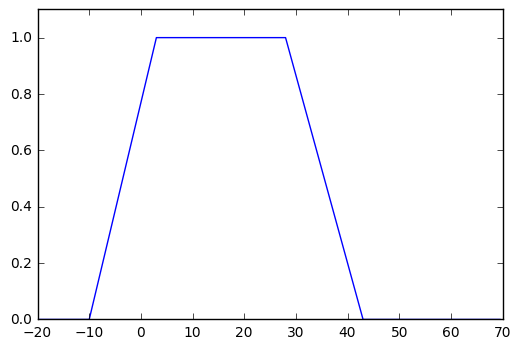

In [66]:
plt.plot(mz,mzh_OT)
plt.title('Example of Membership function')
plt.ylim(0,1.1)

plt.show()


In [68]:
zh_level_ot=np.zeros((zh.shape[0],zh.shape[1]))
zh_level_ws=np.zeros((zh.shape[0],zh.shape[1]))
zh_level_fz=np.zeros((zh.shape[0],zh.shape[1]))
zh_level_rn=np.zeros((zh.shape[0],zh.shape[1]))
zh_level_pl=np.zeros((zh.shape[0],zh.shape[1]))
zh_level_dn=np.zeros((zh.shape[0],zh.shape[1]))
zh_level_ic=np.zeros((zh.shape[0],zh.shape[1]))
zh_level_ag=np.zeros((zh.shape[0],zh.shape[1]))
zh_level_gr=np.zeros((zh.shape[0],zh.shape[1]))
zdr_level_ot=np.zeros((zh.shape[0],zh.shape[1]))
zdr_level_ws=np.zeros((zh.shape[0],zh.shape[1]))
zdr_level_pl=np.zeros((zh.shape[0],zh.shape[1]))
zdr_level_dn=np.zeros((zh.shape[0],zh.shape[1]))
zdr_level_ic=np.zeros((zh.shape[0],zh.shape[1]))
zdr_level_ag=np.zeros((zh.shape[0],zh.shape[1]))
zdr_level_gr=np.zeros((zh.shape[0],zh.shape[1]))
kdp_level_pl=np.zeros((zh.shape[0],zh.shape[1]))
kdp_level_dn=np.zeros((zh.shape[0],zh.shape[1]))
kdp_level_ic=np.zeros((zh.shape[0],zh.shape[1]))
kdp_level_ag=np.zeros((zh.shape[0],zh.shape[1]))
rho_level_ot=np.zeros((zh.shape[0],zh.shape[1]))
rho_level_ws=np.zeros((zh.shape[0],zh.shape[1]))
rho_level_fz=np.zeros((zh.shape[0],zh.shape[1]))
rho_level_rn=np.zeros((zh.shape[0],zh.shape[1]))
rho_level_gr=np.zeros((zh.shape[0],zh.shape[1]))


In [69]:
for ii in range(zh.shape[0]):
    for jj in range(zh.shape[1]):
        
        
        ##### ZH ######
        zh_level_ot[ii,jj] = np.asfarray(fuzz.interp_membership(mz, mzh_OT, zh[ii,jj]))
        zh_level_ws[ii,jj] = fuzz.interp_membership(mz, mzh_WS, zh[ii,jj])
        zh_level_fz[ii,jj] = fuzz.interp_membership(mz, mzh_FZ, zh[ii,jj])
        zh_level_rn[ii,jj] = fuzz.interp_membership(mz, mzh_RN, zh[ii,jj])
        zh_level_pl[ii,jj] = fuzz.interp_membership(mz, mzh_PL, zh[ii,jj])
        zh_level_dn[ii,jj] = fuzz.interp_membership(mz, mzh_DN, zh[ii,jj])
        zh_level_ic[ii,jj] = fuzz.interp_membership(mz, mzh_IC, zh[ii,jj])
        zh_level_ag[ii,jj] = fuzz.interp_membership(mz, mzh_AG, zh[ii,jj])
        zh_level_gr[ii,jj] = fuzz.interp_membership(mz, mzh_GR, zh[ii,jj])

        ##### ZDR ######
        zdr_level_ot[ii,jj] = fuzz.interp_membership(md, mzdr_OT, zdr[ii,jj])
        zdr_level_ws[ii,jj] = fuzz.interp_membership(md, mzdr_WS, zdr[ii,jj])
        zdr_level_pl[ii,jj] = fuzz.interp_membership(md, mzdr_PL, zdr[ii,jj])
        zdr_level_dn[ii,jj] = fuzz.interp_membership(md, mzdr_DN, zdr[ii,jj])
        zdr_level_ic[ii,jj] = fuzz.interp_membership(md, mzdr_IC, zdr[ii,jj])
        zdr_level_ag[ii,jj] = fuzz.interp_membership(md, mzdr_AG, zdr[ii,jj])
        zdr_level_gr[ii,jj] = fuzz.interp_membership(md, mzdr_GR, zdr[ii,jj])

        ##### KDP ######
        kdp_level_pl[ii,jj] = fuzz.interp_membership(mk, mkdp_PL, kdp[ii,jj])
        kdp_level_dn[ii,jj] = fuzz.interp_membership(mk, mkdp_DN, kdp[ii,jj])
        kdp_level_ic[ii,jj] = fuzz.interp_membership(mk, mkdp_IC, kdp[ii,jj])
        kdp_level_ag[ii,jj] = fuzz.interp_membership(mk, mkdp_AG, kdp[ii,jj])

        ##### RHO ######
        rho_level_ot[ii,jj] = fuzz.interp_membership(mr, mrho_OT, rhohv[ii,jj])
        rho_level_ws[ii,jj] = fuzz.interp_membership(mr, mrho_WS, rhohv[ii,jj])
        rho_level_fz[ii,jj] = fuzz.interp_membership(mr, mrho_FZ, rhohv[ii,jj])
        rho_level_rn[ii,jj] = fuzz.interp_membership(mr, mrho_RN, rhohv[ii,jj])
        rho_level_gr[ii,jj] = fuzz.interp_membership(mr, mrho_GR, rhohv[ii,jj])

        

In [74]:
#Weights for Aggregation
wzh=[.16,.16,.33,.33,.2,.2,.48,.24,.45]
wzdr=[.28,.28,.36,.36,.24,.36,.36]
wkdp=[.44,.44,.28,.4]
wrho=[.56,.56,.66,.66,.18]



In [75]:
temp=False
OT_rule=np.add(zh_level_ot*wzh[0],np.add(zdr_level_ot*wzdr[0],rho_level_ot*wrho[0]))/np.sum([wzh[0],wzdr[0],wrho[0]])
WS_rule=np.add(zh_level_ws*wzh[1],np.add(zdr_level_ws*wzdr[1],rho_level_ws*wrho[1]))/np.sum([wzh[1],wzdr[1],wrho[1]])
if temp==True:
    FZ_rule=np.add(zh_level_fz*wzh[2],rho_level_fz*wrho[2])/np.sum((wzh[2],wrho[2]))
else:
    FZ_rule=np.zeros((zh.shape[0],zh.shape[1]))
RN_rule=np.add(zh_level_rn*wzh[3],rho_level_rn*wrho[3])/np.sum((wzh[3],wrho[3]))
PL_rule=np.add(zh_level_pl*wzh[4],np.add(zdr_level_pl*wzdr[2],kdp_level_pl*wkdp[0]))/np.sum([wzh[4],wzdr[2],wkdp[0]])
DN_rule=np.add(zh_level_dn*wzh[5],np.add(zdr_level_dn*wzdr[3],kdp_level_dn*wkdp[1]))/np.sum([wzh[5],wzdr[3],wkdp[1]])
IC_rule=np.add(zh_level_ic*wzh[6],np.add(zdr_level_ic*wzdr[4],kdp_level_ic*wkdp[2]))/np.sum([wzh[6],wzdr[4],wkdp[2]])
AG_rule=np.add(zh_level_ag*wzh[7],np.add(zdr_level_ag*wzdr[5],kdp_level_ag*wkdp[3]))/np.sum([wzh[7],wzdr[5],wkdp[3]])
GR_rule=np.add(zh_level_gr*wzh[8],np.add(zdr_level_gr*wzdr[6],rho_level_gr*wrho[4]))/np.sum([wzh[8],wzdr[6],wrho[4]])



In [76]:
####Correct for Melting layer
bx=np.transpose(np.matlib.repmat(beam_height,zh.shape[1],1))
for ii in range(len(mltnew)):
    fz=FZ_rule[:,ii]
    rn=RN_rule[:,ii]
    ot=OT_rule[:,ii]
    ws=WS_rule[:,ii]
    dn=DN_rule[:,ii]
    pl=PL_rule[:,ii]
    ic=IC_rule[:,ii]
    ag=AG_rule[:,ii]

    if ~np.isnan(mltnew[ii]):
        fz[bx[:,ii]>mlbnew[ii]]=np.nan
        rn[bx[:,ii]>mlbnew[ii]]=np.nan    
        ws[(bx[:,ii]>mltnew[ii])|(bx[:,ii]<mlbnew[ii])]=np.nan
        '''for ii in range(zh.shape[1]):
            if np.isnan(mltnew[ii]):
                WS_rule[ii]=0
        '''
        ot[(bx[:,ii]>mltnew[ii])|(bx[:,ii]<mlbnew[ii])]=np.nan
        ag[bx[:,ii]<mltnew[ii]]=np.nan
        dn[bx[:,ii]<mltnew[ii]]=np.nan
        ic[bx[:,ii]<mltnew[ii]]=np.nan
        pl[bx[:,ii]<mltnew[ii]]=np.nan
    else:
        ws=np.nan
        ot=np.nan
    FZ_rule[:,ii]=fz
    RN_rule[:,ii]=rn
    WS_rule[:,ii]=ws
    OT_rule[:,ii]=ot
    AG_rule[:,ii]=ag
    DN_rule[:,ii]=dn
    IC_rule[:,ii]=ic
    PL_rule[:,ii]=pl

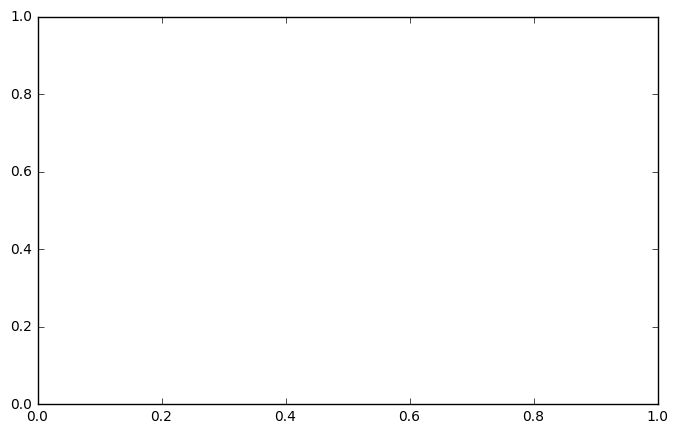

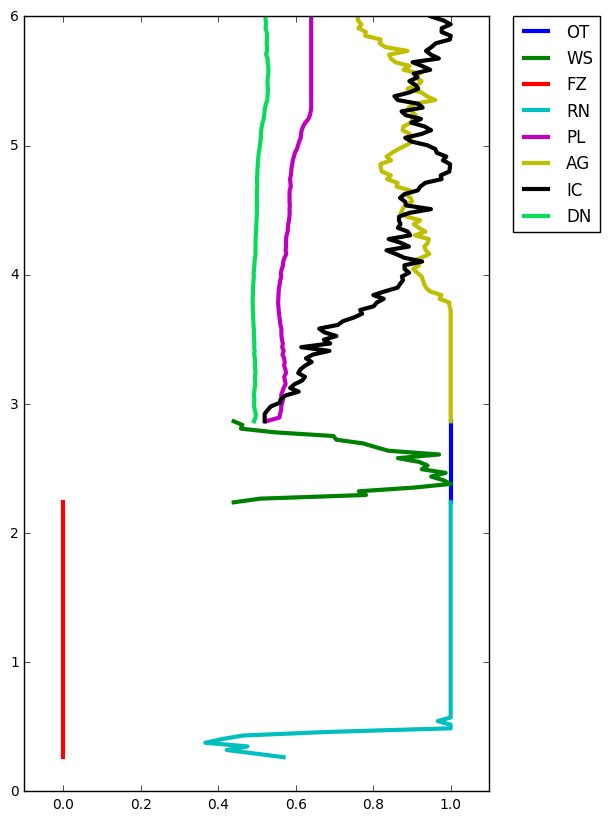

In [77]:
hh=10
fig, ax = plt.subplots(nrows = 1, ncols=1, figsize=(6,10) )
plt.plot(OT_rule[:,hh],beam_height,label='OT',linewidth=3)
plt.plot(WS_rule[:,hh],beam_height,label='WS',linewidth=3)
plt.plot(FZ_rule[:,hh],beam_height,label='FZ',linewidth=3)
plt.plot(RN_rule[:,hh],beam_height,label='RN',linewidth=3)
plt.plot(PL_rule[:,hh],beam_height,label='PL',linewidth=3)
plt.plot(AG_rule[:,hh],beam_height,label='AG',linewidth=3)
plt.plot(IC_rule[:,hh],beam_height,label='IC',linewidth=3)
plt.plot(DN_rule[:,hh],beam_height,label='DN',linewidth=3,color=[0.03,.86,.36])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlim(-.1,1.1)
plt.ylim(0,6)
plt.show()

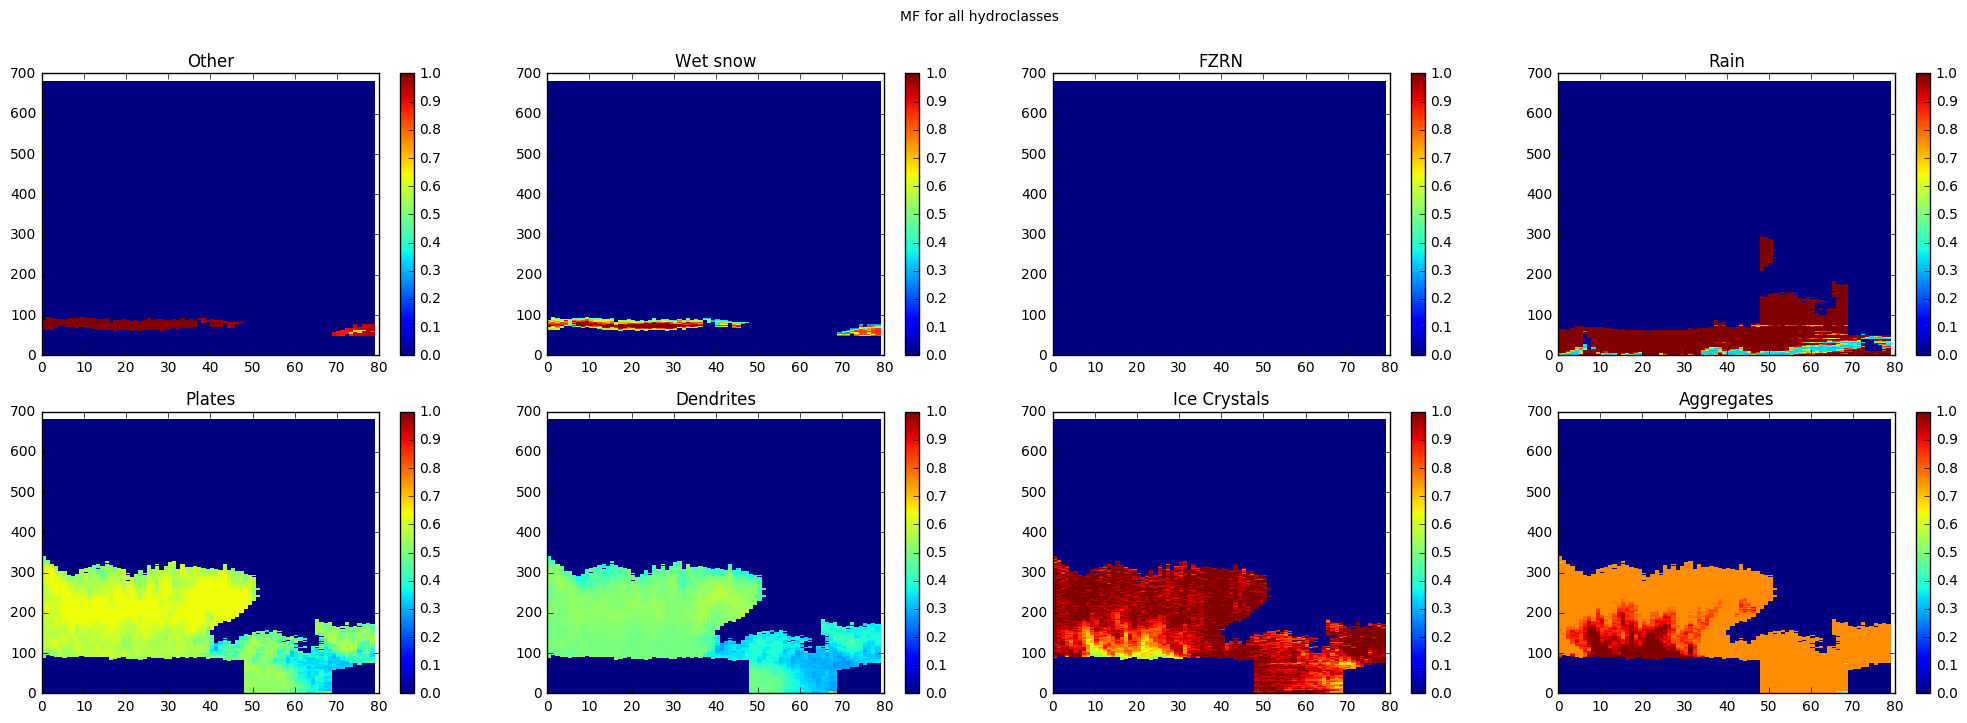

In [80]:
plot_width=25
plot_height=8
fig1 = plt.figure(figsize=(plot_width, plot_height))    

plt.subplot(2,4,1)
plt.pcolormesh(OT_rule,vmin=0,vmax=1)
plt.title('Other')
plt.colorbar()
plt.subplot(2,4,2)
plt.pcolormesh(WS_rule,vmin=0,vmax=1)
plt.title('Wet snow')
plt.colorbar()
plt.subplot(2,4,3)
plt.pcolormesh(FZ_rule,vmin=0,vmax=1)
plt.title('FZRN')
plt.colorbar()
plt.subplot(2,4,4)
plt.pcolormesh(RN_rule,vmin=0,vmax=1)
plt.title('Rain')
plt.colorbar()

plt.subplot(2,4,5)
plt.pcolormesh(PL_rule,vmin=0,vmax=1)
plt.title('Plates')
plt.colorbar()

plt.subplot(2,4,6)
plt.pcolormesh(DN_rule,vmin=0,vmax=1)
plt.title('Dendrites')
plt.colorbar()

plt.subplot(2,4,7)
plt.pcolormesh(IC_rule,vmin=0,vmax=1)
plt.colorbar()
plt.title('Ice Crystals')

plt.subplot(2,4,8)
plt.pcolormesh(AG_rule,vmin=0,vmax=1)
plt.colorbar()
plt.title('Aggregates')
#plt.savefig('/Volumes/RadarDrive/HC/images/'+fname+'_classes.png', bbox_inches='tight')
plt.suptitle('MF for all hydroclasses')
plt.show()



In [81]:
Hclass=np.zeros((zh.shape[0],zh.shape[1],7))
HC=np.zeros((zh.shape[0],zh.shape[1]))
for ii in range(zh.shape[0]):
    for jj in range(zh.shape[1]):
        otmax=OT_rule[ii,jj]
        wsmax=WS_rule[ii,jj]
        
        fzmax=FZ_rule[ii,jj]
        rnmax=RN_rule[ii,jj]
        
        plmax=PL_rule[ii,jj]
        icmax=IC_rule[ii,jj]
        dnmax=DN_rule[ii,jj]
        agmax=AG_rule[ii,jj]
        Hclass[ii,jj,:]=[otmax,wsmax,rnmax,plmax,icmax,dnmax,agmax]
        if np.nansum(Hclass[ii,jj,:])>0:
            HC[ii,jj]=np.nanargmax(Hclass[ii,jj,:])
        else:
            HC[ii,jj]=np.nan

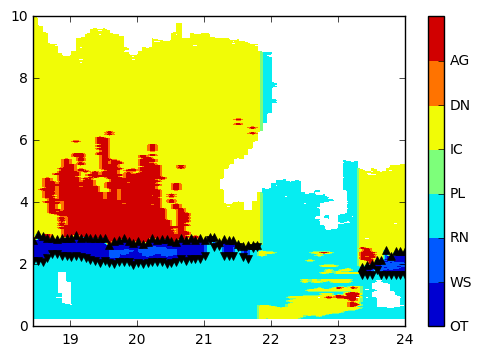

In [84]:
#[wsmax,rnmax,plmax,icmax,dnmax,agmax]
plt.subplot(1,1,1)
clevs=[-1,0,1,2,3,4,5,6]
cbar_labels=['OT','WS','RN','PL','IC','DN','AG']
plt.contourf(tradar, beam_height,HC,levels=clevs,cmap='jet')
plt.plot(tradar,mlt,'k^',tradar,mlb,'kv')
cbar=plt.colorbar()
cbar.set_ticklabels(cbar_labels)

plt.ylim(0,10)
#plt.savefig('/Volumes/RadarDrive/HC/images/'+fname+'.png', bbox_inches='tight')
plt.show()


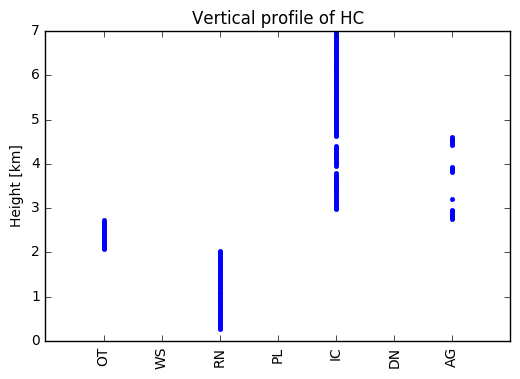

In [88]:
plt.plot(HC[:,30],beam_height,'b.')
plt.xlim(-1,7)
labels=['OT','WS','RN','PL','IC','DN','AG']
x=np.arange(7)
plt.xticks(x, labels, rotation='vertical')
plt.ylabel('Height [km]')
plt.ylim(0,7)

plt.title('Vertical profile of HC')
plt.show()
